# Frame interpolation

In [1]:
%matplotlib inline
import cv2
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import argparse

from scipy.ndimage import convolve, maximum_filter
from scipy.linalg import solve

from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting

# interactive notebook widgets
import ipywidgets as widgets


In [2]:
def imshow(images, titles, nrows = 0, ncols=0, figsize = (20,25)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional


## Farneback Optical Flow


In [3]:

def interpolate_frames_Farneback(frame1, frame2):
    # Convert frames to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow using Farneback algorithm
    flow_f = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 5, 3, 7, 1.5, 0)
    flow_b = cv2.calcOpticalFlowFarneback(gray2, gray1, None, 0.5, 3, 5, 3, 7, 1.5, 0)

    # Interpolate frames with forward and backward flows
    height, width = gray1.shape
    interpolated_frame_f = gray1.copy()
    interpolated_frame_b = gray2.copy()
    
    # Use optical flow to estimate the new position of the pixels
    dx_f, dy_f = (flow_f[:,:,0]/2).astype(int), (flow_f[:,:,1]/2).astype(int)
    dx_b, dy_b = (flow_b[:,:,0]/2).astype(int), (flow_b[:,:,1]/2).astype(int)

    for y in range(height):
        for x in range(width):
            new_x = x + dx_f[y, x]
            new_y = y + dy_f[y, x]
            
            # Ensure the new coordinates are within the image boundaries
            if 0 <= new_x < width and 0 <= new_y < height:
                interpolated_frame_f[new_y, new_x] = gray1[y, x]
                
            new_x = x + dx_b[y, x]
            new_y = y + dy_b[y, x]
            
            if 0 <= new_x < width and 0 <= new_y < height:
                interpolated_frame_b[new_y, new_x] = gray2[y, x]
    
    return cv2.addWeighted(interpolated_frame_f, 0.5, interpolated_frame_b, 0.5, 0.0)


In [5]:
# Perform frame interpolation on a sample video: input is 25 fps, output is 50fps
cap = cv2.VideoCapture("sample.mp4")
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 50, (1920,1080))

pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
flag, frame_1 = cap.read()

if flag:
    # The frame is ready and already captured

    pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
    print(str(pos_frame)+" frames")
while True:

    flag, frame_2 = cap.read()
    
    out.write(frame_1)
    
    if flag:
        # The frame is ready and already captured

        pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        print(str(pos_frame)+" frames")
    
    interpolated_frame = interpolate_frames_Farneback(frame_1, frame_2)
    interpolated_frame = cv2.cvtColor(interpolated_frame, cv2.COLOR_GRAY2BGR)
    out.write(interpolated_frame)

    frame_1 = frame_2
    
    if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
        # If the number of captured frames is equal to the total number of frames, we stop
        break

cap.release()
out.release()


1.0 frames
2.0 frames
3.0 frames
4.0 frames
5.0 frames
6.0 frames
7.0 frames
8.0 frames
9.0 frames
10.0 frames
11.0 frames
12.0 frames
13.0 frames
14.0 frames
15.0 frames
16.0 frames
17.0 frames
18.0 frames
19.0 frames
20.0 frames
21.0 frames
22.0 frames
23.0 frames
24.0 frames
25.0 frames
26.0 frames
27.0 frames
28.0 frames
29.0 frames
30.0 frames
31.0 frames
32.0 frames
33.0 frames
34.0 frames
35.0 frames
36.0 frames
37.0 frames
38.0 frames
39.0 frames
40.0 frames
41.0 frames
42.0 frames
43.0 frames
44.0 frames
45.0 frames
46.0 frames
47.0 frames
48.0 frames
49.0 frames
50.0 frames
51.0 frames
52.0 frames
53.0 frames
54.0 frames
55.0 frames
56.0 frames
57.0 frames
58.0 frames
59.0 frames
60.0 frames
61.0 frames
62.0 frames
63.0 frames
64.0 frames
65.0 frames
66.0 frames
67.0 frames
68.0 frames
69.0 frames
70.0 frames
71.0 frames
72.0 frames
73.0 frames
74.0 frames
75.0 frames
76.0 frames
77.0 frames
78.0 frames
79.0 frames
80.0 frames
81.0 frames
82.0 frames
83.0 frames
84.0 frames
8

## Lucas Kanade Optical Flow


In [6]:
def gradient_y_sobel(img):
  '''Computes the Y gradient of img'''
  img = img.astype(float)
  sobel_y = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
  return convolve(img, sobel_y)/8


def gradient_x_sobel(img):
  '''Computes the X gradient of img'''
  img = img.astype(float)
  sobel_x = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
  return convolve(img, sobel_x)/8

def cut(corners, qualityLevel, min_eigenvalue):
    '''Using dichotomia, removes corners that don't have the required quality level, measured as a fraction of the quality of the best corner'''
    if qualityLevel is None:
      return corners
  
    threshold = min_eigenvalue[corners[0][0][1],corners[0][0][0]] * qualityLevel
    low, high = 0, len(corners) - 1

    while low <= high:
          mid = (low + high) // 2
          mid_value = min_eigenvalue[corners[mid][0][1], corners[mid][0][0]]

          if mid_value >= threshold:
              low = mid + 1
          else:
              high = mid - 1
  
    return corners[:low]


def optical_flow(image, next_image, window_size, sigma, maxCorners=None, qualityLevel=None, blockSize=25):
    '''
    Extracts corners in "image" using the Shi-Tomasi method. In addition, it computes the optical flow for the corners using the Lucas-Kanade method.
    window_size and sigma: used to compute the gaussian kernel
    blockSize: used when removing corners that aren't local maxima
    '''
    # Create a gaussian kernel with desired size
    dirac = np.zeros((window_size+2, window_size+2))
    center = window_size//2 + 1
    dirac[center,center] = 1
    gaussian_kernel = cv2.GaussianBlur(dirac, (window_size, window_size), sigmaX=sigma, sigmaY=sigma)

    # Compute the image gradients
    sobel_x = gradient_x_sobel(image.copy())
    sobel_y = gradient_y_sobel(image.copy())
    sobel_x_2 = sobel_x**2
    sobel_y_2 = sobel_y**2
    sobel_xy = sobel_x*sobel_y

    # Compute the H matrices
    A = convolve(sobel_x_2, gaussian_kernel)
    B = convolve(sobel_xy, gaussian_kernel)
    C = convolve(sobel_y_2, gaussian_kernel)

    # Compute the minimal eigenvalues for each H
    min_eigenvalue = 0.5*(A+C-np.sqrt(4*B**2 + (A-C)**2))

    # We want to keep the local maxima only
    local_maxima = min_eigenvalue == maximum_filter(min_eigenvalue, size=(blockSize, blockSize))
    min_eigenvalue = min_eigenvalue*local_maxima

    corners = [[[j,i]] for j in range(image.shape[1]) for i in range(image.shape[0])]
    corners = sorted(corners, key=lambda x: min_eigenvalue[x[0][1],x[0][0]], reverse=True)

    # Keeping only desired corners
    if maxCorners is not None:
        corners = corners[:maxCorners]
    corners = cut(corners, qualityLevel, min_eigenvalue)

    # Compute the optical flow using the Lucas-Kanade method
    # Calculate the derivative of the image with respect to t
    sobel_t = next_image - image
    Tx = convolve(sobel_x*sobel_t, gaussian_kernel)
    Ty = convolve(sobel_y*sobel_t, gaussian_kernel)

    # Solve the LK linear system
    velocities = []
    for c in corners:
        x,y = c[0][0], c[0][1]
        velocities.append(solve(np.array([[A[y,x], B[y,x]], [B[y,x], C[y,x]]]), -np.array([[Tx[y,x]], [Ty[y,x]]])).transpose())

    return np.array(corners).astype(np.float32), (np.array(corners) + np.array(velocities) / 2).astype(np.float32) # We divide velocities by 2 to estimate the pixel positions between the two frames


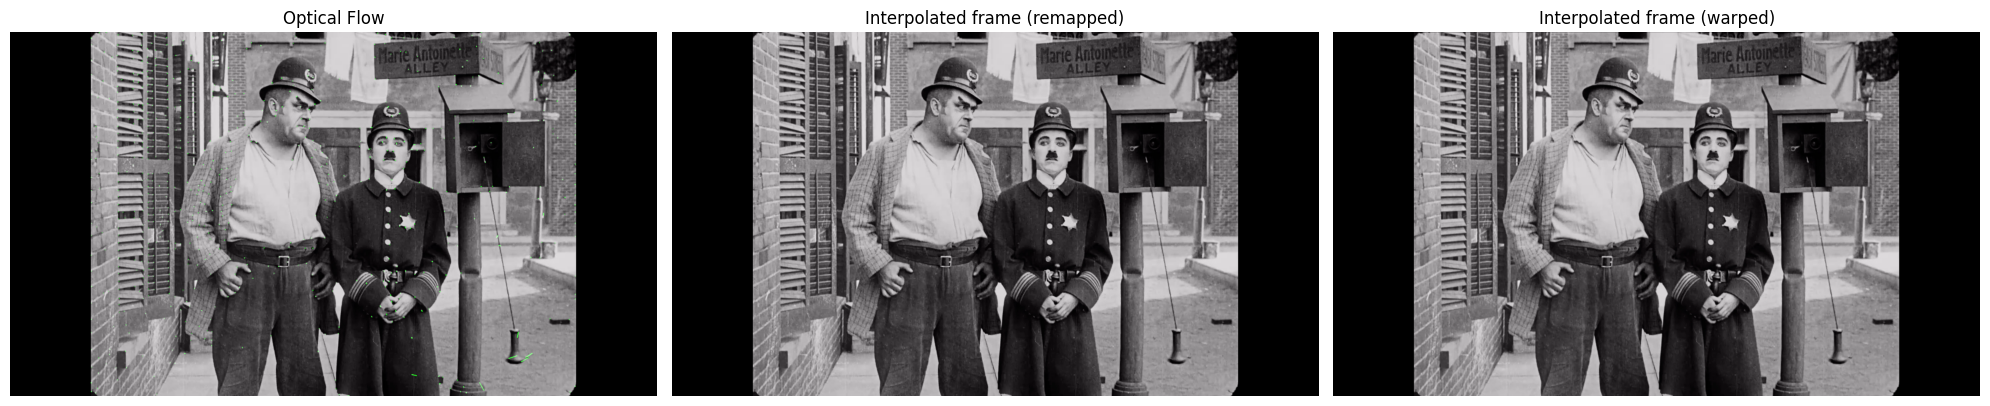

In [7]:
def interpolate_frame_lk(prev_frame, next_frame, useOpencv=True):
    '''Performs frame interpolation using the Lucas-Kanade method'''

    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    if useOpencv:
        # Find initial keypoints using Shi-Tomasi corner detection
        prev_pts, _ = optical_flow(prev_gray, next_gray, 5, 1, 1000, qualityLevel=0.05, blockSize=25)

        # Calculate optical flow using Lucas-Kanade method
        next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, prev_pts, None)
    else:
        # Find initial keypoints using Shi-Tomasi corner detection and calculate optical flow using Lucas-Kanade method
        prev_pts, next_pts = optical_flow(prev_gray, next_gray, 5, 1, 1000, qualityLevel=0.05, blockSize=25)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(prev_frame)

    # Draw the tracks on the mask
    for new, old in zip(next_pts, prev_pts):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
        next_frame = cv2.circle(next_frame, (int(a), int(b)), 5, (0, 0, 255), -1)
    

    # Overlay the optical flow tracks on the original frame
    optical_flow_frame = cv2.add(prev_frame, mask)

    # 1st interpolation method: create a remap map
    map_x = np.arange(prev_frame.shape[1]).astype(np.float32)
    map_y = np.arange(prev_frame.shape[0]).astype(np.float32)
    map_x, map_y = np.meshgrid(map_x, map_y)

    # Update the map based on the displacement
    for i in range(len(prev_pts)):
        map_x[round(prev_pts[i, 0, 1]), round(prev_pts[i, 0, 0])] = next_pts[i, 0, 0]
        map_y[round(prev_pts[i, 0, 1]), round(prev_pts[i, 0, 0])] = next_pts[i, 0, 1]
    
    # Remap the image
    remapped_image = cv2.remap(prev_frame, map_x, map_y, interpolation=cv2.INTER_LINEAR)

    # 2nd interpolation method: create a transformation matrix based on the calculated flow
    M = cv2.estimateAffinePartial2D(prev_pts, next_pts)[0]

    # Warp the previous frame using the transformation matrix
    warped_frame = cv2.warpAffine(prev_frame, M, (prev_frame.shape[1], prev_frame.shape[0]))

    return optical_flow_frame, remapped_image, warped_frame


# Read two frames
frame1 = cv2.imread('frame1.jpg')
frame2 = cv2.imread('frame2.jpg')

# Perform frame interpolation
optical_flow_frame, remapped, warped = interpolate_frame_lk(frame1, frame2, True)

# Display the interpolated frames
imshow([optical_flow_frame, remapped, warped], ['Optical Flow', 'Interpolated frame (remapped)', 'Interpolated frame (warped)'])


## Feature matching to compute the optical flow


In [8]:

def keypoint_detection_and_description(image, window_size, sigma, maxCorners=None, qualityLevel=None, blockSize=25):
    '''
    Extracts keypoints using the Shi-Tomasi method. Then, applies the SIFT algorithm to compute, for each keypoint, an orientation and a 128-dimensional descriptor.
    window_size and sigma: used to compute the gaussian kernel
    blockSize: used when removing corners that aren't local maxima
    '''
    # Create a gaussian kernel with desired size
    dirac = np.zeros((window_size+2, window_size+2))
    center = window_size//2 + 1
    dirac[center,center] = 1
    gaussian_kernel = cv2.GaussianBlur(dirac, (window_size, window_size), sigmaX=sigma, sigmaY=sigma)
    
    # Compute the image gradients
    sobel_x = gradient_x_sobel(image.copy())
    sobel_y = gradient_y_sobel(image.copy())
    sobel_x_2 = sobel_x**2
    sobel_y_2 = sobel_y**2
    sobel_xy = sobel_x*sobel_y

    # Compute the H matrices
    A = convolve(sobel_x_2, gaussian_kernel)
    B = convolve(sobel_xy, gaussian_kernel)
    C = convolve(sobel_y_2, gaussian_kernel)

    # Compute the minimal eigenvalues for each H
    min_eigenvalue = 0.5*(A+C-np.sqrt(4*B**2 + (A-C)**2))

    # We want to keep the local maxima only
    local_maxima = min_eigenvalue == maximum_filter(min_eigenvalue, size=(blockSize, blockSize))
    min_eigenvalue = min_eigenvalue*local_maxima

    corners = [[[j,i]] for j in range(image.shape[1]) for i in range(image.shape[0])]
    corners = sorted(corners, key=lambda x: min_eigenvalue[x[0][1],x[0][0]], reverse=True)

    # Keeping only desired corners
    if maxCorners is not None:
        corners = corners[:maxCorners]
    corners = cut(corners, qualityLevel, min_eigenvalue)
    
    # For each pixel, we calculate the gradient magnitude and angle
    magnitude = np.sqrt(sobel_x_2 + sobel_y_2)
    teta = np.arctan2(sobel_y, sobel_x, out=np.zeros_like(sobel_x), where=sobel_x!=0)*180/np.pi
    error = sobel_x!=0
    magnitude = magnitude * error # the pixels for which sobel_x = 0 shouldn't be taken into account in the histograms
    teta[teta<0]+=360
    
    # For the SIFT algorithm, angles are split in 36 intervals
    teta_reduced = np.round(teta/10).astype(int)
    teta_reduced[teta_reduced==36] = 0
    
    # Compute keypoint orientations
    key_points = []

    for c in corners:
       if 0<=c[0][1] - 7 and c[0][1] + 7 < image.shape[0] and 0<=c[0][0] - 7 and c[0][0] + 7 < image.shape[1]: 
        # this way we won't have border issues when generating the SIFT descriptors
        # Build a weighted histogram of the orientation of the keypoint neighbors
        histogram = [0] * 36
        for y in range(c[0][1] - window_size//2, c[0][1] + window_size//2 + 1):
            for x in range(c[0][0] - window_size//2, c[0][0] + window_size//2 + 1):
                histogram[teta_reduced[y, x]] += magnitude[y, x]*gaussian_kernel[y - c[0][1] + window_size//2 + 1, x - c[0][0] + window_size//2 + 1]
        
        # Keep only the dominant orientations (keypoints with the same coordinates but different orientations can exist)
        orientation_max = max(histogram)
        for i in range(len(histogram)):
            if histogram[i] > 0.8*orientation_max:
              key_points.append([c[0][0], c[0][1], i])
    
    # Create a new gaussian kernel to compute SIFT descriptors
    descriptors = []
    dirac = np.zeros((17, 17))
    center = 8
    dirac[center,center] = 1
    gaussian_kernel = cv2.GaussianBlur(dirac, (15, 15), sigmaX=sigma, sigmaY=sigma)
    
    # Compute the descriptor (we use a 15*15 grid instead of 16*16)
    for kp in key_points:
       new_dsc = np.array([])
       initial_x, initial_y, angle = kp[0]-7, kp[1]-7, kp[2]*10
       start_x = [initial_x, initial_x+4, initial_x+7, initial_x+11]
       start_y = [initial_y, initial_y+4, initial_y+7, initial_y+11]
       for o_x in start_x:
          for o_y in start_y:
             histogram = [0]*8
             for x in range(o_x, o_x+4):
                for y in range(o_y, o_y+4):
                   # Substracting the keypoint orientation to the gradient angles makes the descriptor invariant to rotation
                   histogram[np.round((teta[y, x]-angle)/45).astype(int) % 8] += magnitude[y, x]*gaussian_kernel[y-kp[1]+8, x-kp[0]+8]
             new_dsc = np.append(new_dsc, histogram)
       
       # Post-process the descriptor to make it compliant with opencv's conventions
       threshold = linalg.norm(new_dsc) * 0.2
       new_dsc[new_dsc>threshold] = threshold

       new_dsc /= linalg.norm(new_dsc)
       new_dsc = np.round(512 * new_dsc).astype(int)
       new_dsc[new_dsc < 0] = 0
       new_dsc[new_dsc > 255] = 255

       descriptors.append(new_dsc)
    
    # Standardize the output to be able to use opencv's matchers
    kps = []
    for kp in key_points:
       kps.append(cv2.KeyPoint(kp[0], kp[1], 1, angle=kp[2]*10))
    
    return np.array(kps), np.array(descriptors, dtype='float32')


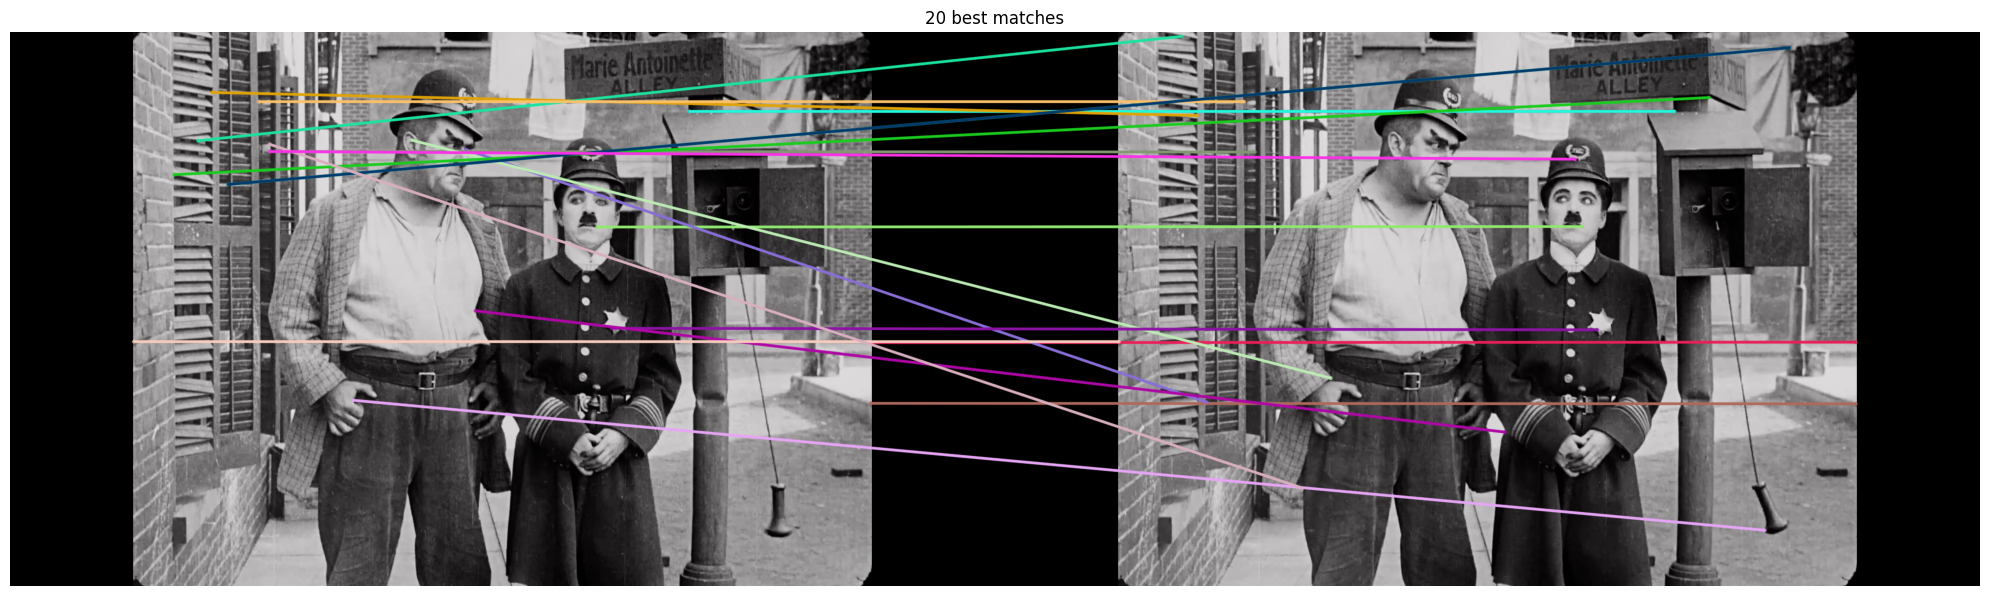

In [9]:
image1 = cv2.imread('frame1.jpg')
image2 = cv2.imread('frame2.jpg')

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Perform feature extraction and description
kp1, des1 = keypoint_detection_and_description(gray1, 5, 1, 1000, 0.05)
kp2, des2 = keypoint_detection_and_description(gray2, 5, 1, 1000, 0.05)

def match_key_points(des1, des2):
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    # Match descriptors
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance
    return sorted(matches, key = lambda x:x.distance)

def showMatches(img1, kp1, img2, kp2, matches, name):
    img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=3)
    imshow([img],[name])

matches = match_key_points(des1,des2)
showMatches(image1,kp1,image2,kp2,matches[:20],"20 best matches")

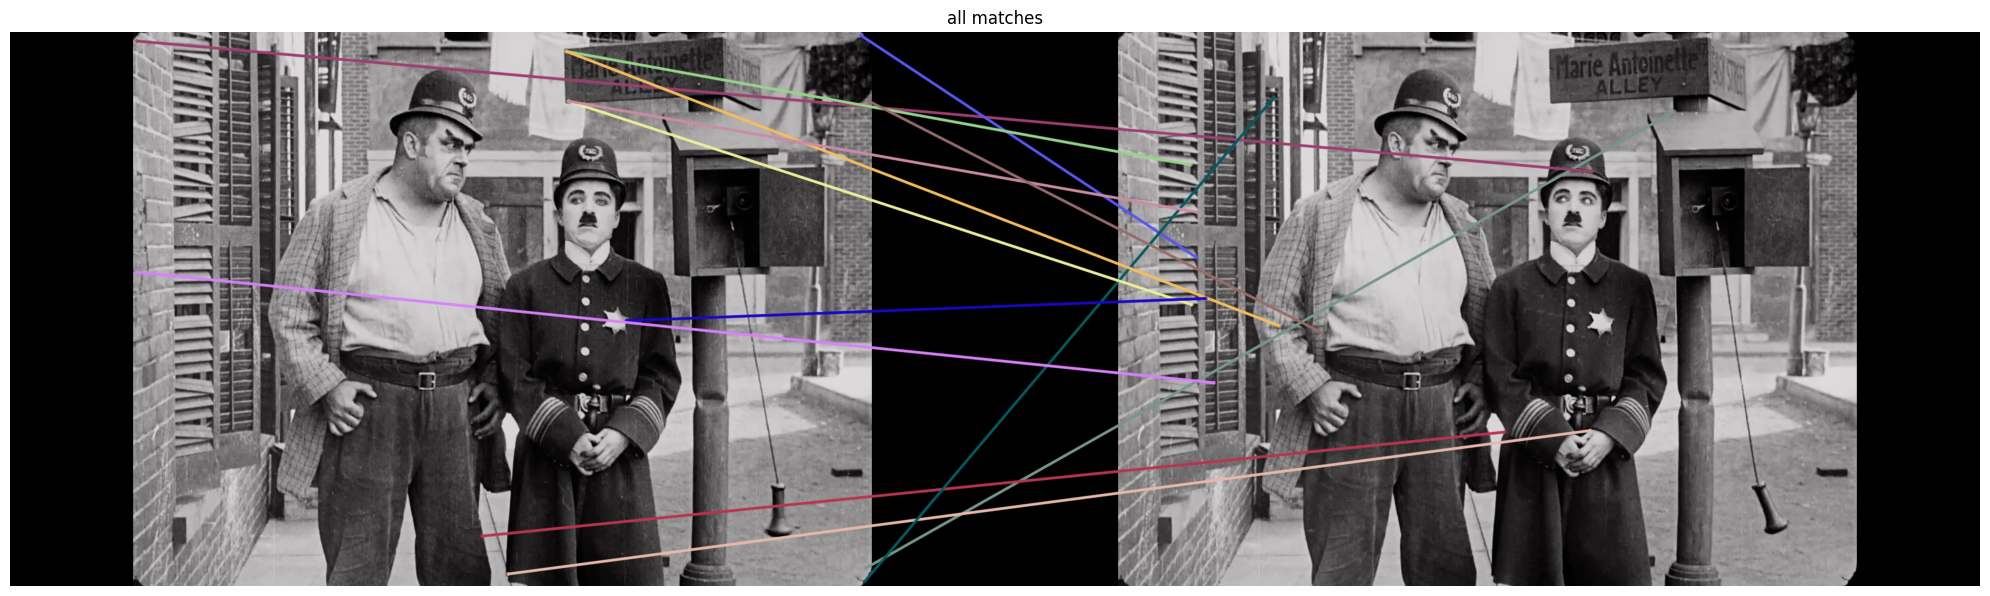

In [10]:
# Compare with OpenCV's SIFT implementation
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1,None)
kp1, des1 = sift.detectAndCompute(gray2,None)
matches = match_key_points(des1,des2)
showMatches(image1,kp1,image2,kp2,matches,"all matches")